En este notebook, implementaremos redes bayesianas con ayuda de la librería pyAgrum. El dataset utilizado, que es sobre diagnósticos de COVID-19 se puede encontrar en: https://www.kaggle.com/datasets/einsteindata4u/covid19/data

# Redes Bayesianas


Las **redes bayesianas** son una clase de Modelos Gráficos Probabilísticos populares por su capacidad de razonar bajo incertidumbre.

Pueden ser vistas como un sistema experto probabilístico: el conocimiento del dominio o problema se modela como un grafo acíclico dirigido. Los enlaces (arcos) del grafo representan las dependencias probabilísticas (correlación, causalidad o influencia) entre los nodos/variables del dominio.

Las redes bayesianas pueden ayudarnos a tomar decisiones más informadas de cara a la incertidumbre, así como para observar relaciones complejas entre nuestros datos.


## Más formalmente...

Más formalmente, una red bayesina es una **Distribución de Probabilidad Conjunta** sobre un conjunto de variables aleatorias. Se representa mediante un grafo, donde los nodos se identifican con variables aleatorias y los arcos expresan la dependencia probabilística entre ellos.

Para poner en perspectiva a estas redes, considere una Unidad de Cuidados Intensivos (UCI) de un hospital. Los profesionales de la salud necesitan tener una idea de si una persona requerirá cuidados intensivos en un futuro inmediato para poder asignar mejor sus recursos.

El ingreso en UCI puede deberse a Covid-19 o no. Algunos biomarcadores están asociados con una mayor probabilidad de tener Covid-19 y pueden identificarse con relativa facilidad mediante un análisis de sangre. De manera similar, otros indicadores no necesariamente vinculados a Covid-19 también pueden estar relacionados con otras comorbilidades que aumentan la probabilidad de ingreso en UCI.

La red bayesiana se encarga de factorizar a nuestra distribución de probabilidad conjunta en un producto de distribuciones de probabilidad condicionales, las cuales se pueden obtener de manera frecuentista de un dataset, o través de conocimiento experto.

La estructura gráfica codifica información muy interesante que puede ser utilizada para obtener información sobre los datos. Por ejemplo, cada nodo es **independiente** de sus no descendientes dado sus padres en el grafo. Esta es la propiedad Markoviana en la red bayesiana.

## Aplicaciones

En nuestro caso, utilizaremos redes bayesianas para diagnóstico, predicción y explicación probable de una observación. Una vez que tenemos la red y el parámetro cuantitativo (CPT), podemos comenzar a razonar bajo incertidumbre (hacer inferencia). Esto consiste en calcular una distribución posterior, como P(covid_19 = 1 | Plaquetas = 3, Influenza B = no detectada).









## pyAgrum

PyAgrum es una biblioteca dedicada a las redes bayesianas y otros modelos gráficos probabilísticos. Se basa en la biblioteca C++ aGrUM, proporcionando una interfaz de alto nivel para crear, gestionar y realizar cálculos eficientes con redes bayesianas y otros modelos gráficos probabilísticos.



In [1]:
!pip install pyagrum==0.22.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.4 MB/s eta 0:00:00


In [2]:
!pip install pydotplus==2.0.2

## Imports

In [4]:
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Funciones auxiliares

def missing(df,perc=0):
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['column', 'missing count']
    missing_df['percentage']=(missing_df['missing count'])/df.shape[0]*100
    missing_df = missing_df[missing_df.percentage>perc]
    print('# columns containing missing values',len(missing_df))
    print("missing_columns=" , list(missing_df.column))
    return missing_df.sort_values(by='percentage',ascending=False)

def show_unique(df):
    '''Columnas con un solo valor no tienen variabilidad que podamos explotar'''
    counts = pd.DataFrame()
    counts['nunique'] = df.nunique()

    counts = counts[counts['nunique'] == 1]
    print('These columns only have one value:', list(counts.index))
    return counts

def fill_null(df, attribute_list, stat = 'intger', integer = -999):
    """
    This function fills null values of selected columns with one of four different methods:
        - 'median' will fill the nulls with the median of the column.
        - 'mean' uses the mean of the column.
        - 'mode' uses the mode of the column. It can be used with string
        variables, but they need to have been encoded first.
        - 'integer' fills the nulls with an integer (-999 by default).
    """
    for i in attribute_list:
        if stat == 'median':
            df[i].fillna(df[i].median(), inplace=True)
        elif stat == 'mean':
            df[i].fillna(df[i].mean(), inplace=True)
        elif stat == 'mode':
            df[i].fillna(df[i].mode()[0], inplace=True)
        elif stat == 'integer':
            df[i].fillna(integer, inplace=True)

    return df


def get_jpd_size(bn):
    return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])

def get_cpts_size(bn):
    return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes() ])

def compression_ratio(bn):
    return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

def post(row,bn,target):
        ie = gum.LazyPropagation(bn)
        evs = row.astype(str).to_dict()
        #print(evs)
        del evs[target]
        ie.setEvidence(evs)
        ie.addTarget(target)
        return ie.posterior(target).toarray()[1]

## Clase Wrapper

In [17]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN
    """
    def __init__(self,
                 csv_template=None,
                 bn=None,
                mandatory_arcs=[],
                tabu_arcs=[],
                class_name = None,
                learning_method='greedy',
                prior='likelihood',
                prior_weight=.5,
                positif_label = None,
                threshold = .5,
                nb_classes = 2,
                cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
                bins=5):


        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn


    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method,
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}


    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)


        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d


    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""

        # create the template
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)


        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)


        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()


        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())
        del template,train

        return self

    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name)

        evs = row.astype(str).to_dict()
        del evs[self.class_name]
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()


    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name)

        for i in range(len(test)):
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores


    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores


    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]

        return y_true, np.where(y_scores >= self.threshold, 1, 0)


    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

## Carga y manejo de datos

In [9]:
df_orig = pd.read_excel('/content/dataset.xlsx')
df = df_orig.copy()
print('Dimensions of data:', df.shape)
df

Dimensions of data: (5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.237,-0.022,-0.517,0.011,0.102,0.318,-0.951,-0.095,-0.224,-0.292,1.482,0.166,0.358,-0.625,-0.141,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619,1.198,-0.148,2.090,-0.306,0.863,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,N

In [10]:
missing(df_orig)

# columns containing missing values 105
missing_columns= ['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Mycoplasma pneumoniae', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium', 'Influenza B, rapid test', 'Influenza A, rapid test', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total B

,column,missing count,percentage
81,Urine - Sugar,5644,100.000
89,Partial thromboplastin time (PTT),5644,100.000
27,Mycoplasma pneumoniae,5644,100.000
93,"Prothrombin time (PT), Activity",5644,100.000
99,D-Dimer,5644,100.000
...,...,...,...
24,Parainfluenza 1,4292,76.045
32,Parainfluenza 4,4292,76.045
21,Respiratory Syncytial Virus,4290,76.010
22,Influenza A,4290,76.010


In [11]:
# Rename some columns
df.rename(columns= {'SARS-Cov-2 exam result': 'covid_19',
                   'Patient addmited to regular ward (1=yes, 0=no)': 'regular_ward',
                   'Patient addmited to semi-intensive unit (1=yes, 0=no)': 'semi_intensive_care',
                   'Patient addmited to intensive care unit (1=yes, 0=no)': 'intensive_care',
                   'Influenza B, rapid test': 'Influenza B rapid test',
                   'Influenza A, rapid test': 'Influenza A rapid test'}, inplace = True)

# Dummify covid_19 var for consistency
df['covid_19'] = df['covid_19'].apply(lambda x :1 if x=='positive' else 0)

# Tira Patient IDs, no se necesitarán
df.drop(columns = 'Patient ID', inplace = True)

In [12]:
df.drop(columns = list(missing(df, perc = 95).column.values), inplace = True)
df.drop(columns = list(show_unique(df).index), inplace = True)
df.shape

# columns containing missing values 65
missing_columns= ['Serum Glucose', 'Mycoplasma pneumoniae', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bilirubin', 'Direct Bilirubin', 'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium\xa0', 'Magnesium', 'pCO2 (venous blood gas analysis)', 'Hb saturation (venous blood gas analysis)', 'Base excess (venous blood gas analysis)', 'pO2 (venous blood gas analysis)', 'Fio2 (venous blood gas analysis)', 'Total CO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)', 'HCO3 (venous blood gas analysis)', 'Rods #', 'Segmented', 'Promyelocytes', 'Metamyelocytes', 'Myelocytes', 'Myeloblasts', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Density', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Sugar', 'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Red blood cells', 'Urine - Hyal

(5644, 44)

In [13]:
kept_cols = [i for i in df if df[i].nunique()<=4]
kept_cols.extend(['Platelets','Red blood Cells','Lymphocytes','Leukocytes'])
kept_cols,len(kept_cols)

(['covid_19',
  'regular_ward',
  'semi_intensive_care',
  'intensive_care',
  'Respiratory Syncytial Virus',
  'Influenza A',
  'Influenza B',
  'Parainfluenza 1',
  'CoronavirusNL63',
  'Rhinovirus/Enterovirus',
  'Coronavirus HKU1',
  'Parainfluenza 3',
  'Chlamydophila pneumoniae',
  'Adenovirus',
  'Parainfluenza 4',
  'Coronavirus229E',
  'CoronavirusOC43',
  'Inf A H1N1 2009',
  'Bordetella pertussis',
  'Metapneumovirus',
  'Influenza B rapid test',
  'Influenza A rapid test',
  'Strepto A',
  'Platelets',
  'Red blood Cells',
  'Lymphocytes',
  'Leukocytes'],
 27)

In [14]:
df = df[kept_cols]
missing(df)

# columns containing missing values 23
missing_columns= ['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Influenza B rapid test', 'Influenza A rapid test', 'Strepto A', 'Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes']


,column,missing count,percentage
22,Strepto A,5312,94.118
26,Leukocytes,5042,89.334
25,Lymphocytes,5042,89.334
24,Red blood Cells,5042,89.334
23,Platelets,5042,89.334
21,Influenza A rapid test,4824,85.471
20,Influenza B rapid test,4824,85.471
16,CoronavirusOC43,4292,76.045
19,Metapneumovirus,4292,76.045
18,Bordetella pertussis,4292,76.045


In [15]:
continuous_cols = [x for x in df.columns if df[x].dtypes == 'float64']
discrete_cols = [x for x in df.columns if (df[x].dtypes == 'O') | (df[x].dtypes == 'int64')]

for i in ['covid_19', 'regular_ward', 'semi_intensive_care','intensive_care']:
    discrete_cols.remove(i)  # Drop targets

df = fill_null(df, continuous_cols, stat = 'median')
df = fill_null(df, discrete_cols, stat = 'integer', integer = '-999')

<ipython-input-4-6e908c78fad2>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].fillna(df[i].median(), inplace=True)
<ipython-input-4-6e908c78fad2>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].fillna(df[i].median(), inplace=True)
<ipython-input-4-6e908c78fad2>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].fillna(df[i].median(), inplace=True)
<ipython-input-4-6e908c78fad2>:54: SettingWithCopyWarning: 
A value

## Redes Bayesianas

In [18]:
df.to_csv('template.csv', index = False)

clf = BNEstimator(csv_template='template.csv', class_name='covid_19',
                  cut_points_percentiles = [5, 50, 95])

_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv('train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='covid_19', csv_template='template.csv',
            cut_points_percentiles=[5, 50, 95])

<ipython-input-19-bff000f84482>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gnb.showBN(clf.bn,size=12,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))


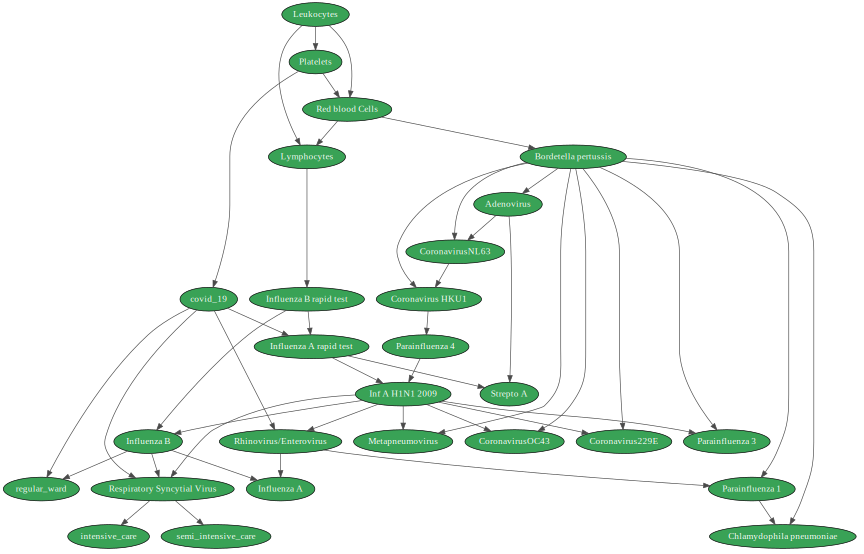

In [19]:
gnb.showBN(clf.bn,size=12,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))

La estructura aprendida puede contener algunas relaciones que no tienen sentido desde un punto de vista práctico. Aquí hay otra característica importante de las redes bayesianas: el experto en el dominio puede intervenir para codificar el conocimiento del negocio en el proceso de aprendizaje.

<ipython-input-20-c22c821b1ea1>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gnb.showBN(clf.bn,size=8,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Oranges'))


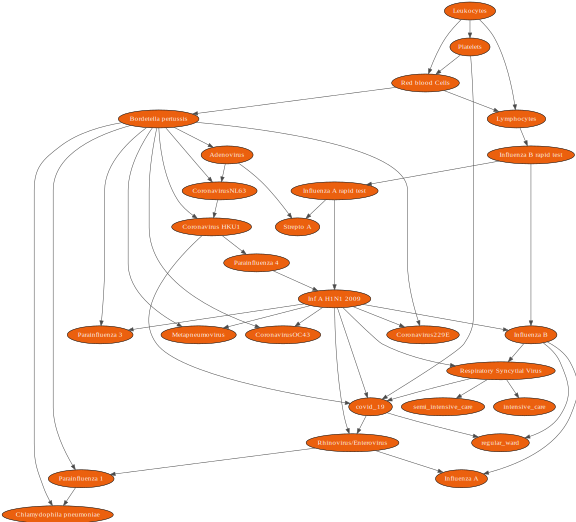

In [20]:
df.to_csv('template.csv', index = False)

clf = BNEstimator(csv_template='template.csv', class_name='covid_19',
                  tabu_arcs=[('Influenza B rapid test', 'covid_19')],
                  mandatory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19')],
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

clf.fit(train)

gnb.showBN(clf.bn,size=8,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Oranges'))

Ahora, podemos observar las probabilidades condicionales aprendidas por el modelo.

In [22]:
clf.bn.cpt(clf.bn.idFromName('regular_ward'))

(pyAgrum.Potential<double>@0x5731e7df51e0) 
             ||  regular_ward     |
Influe|covid_||0        |1        |
------|------||---------|---------|
-999  |0     || 0.9975  | 0.0025  |
not_de|0     || 0.9705  | 0.0295  |
detect|0     || 0.9983  | 0.0017  |
-999  |1     || 0.9795  | 0.0205  |
not_de|1     || 0.7495  | 0.2505  |
detect|1     || 0.9286  | 0.0714  |

Y podemos escoger visualizar sábanas de Markov.

In [23]:
gum.MarkovBlanket(clf.bn,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7b068e3b5380> >

## Inferencia

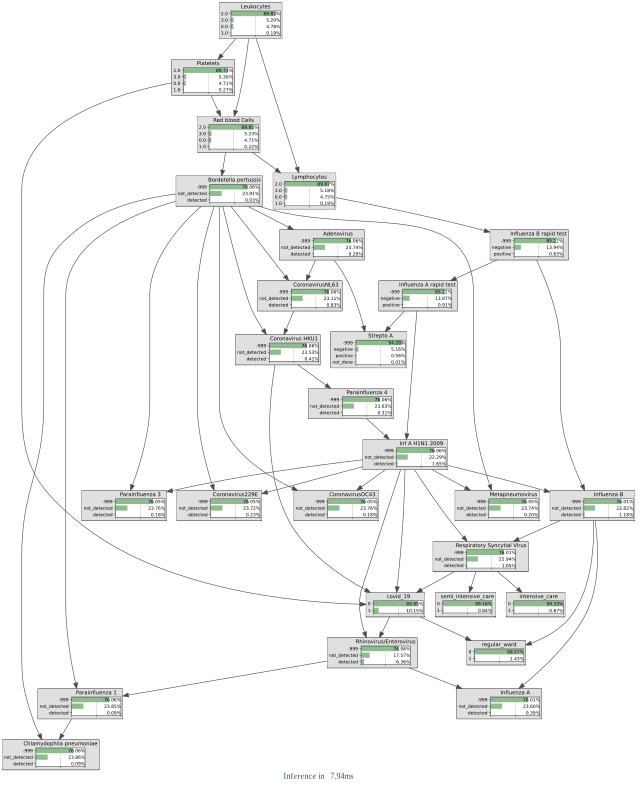

In [24]:
gnb.showInference(clf.bn,size=11)

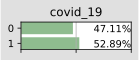

In [25]:
gnb.showPosterior(clf.bn, evs={'Platelets':'3.0', 'Influenza B':'detected',
                               'Coronavirus HKU1':'not_detected'},
                  target='covid_19')# Especifiamos el target que queremos analizar, dado un cuadro clínico

Recordar la independencia implícita...

In [26]:
gum.MarkovBlanket(clf.bn,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7b0685d31710> >

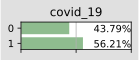

In [27]:
d_test = pd.read_csv('test.csv')
row = d_test.loc[1,:]
evs = row.astype(str).to_dict()

evidence = {'Platelets': '3.0',
            'Inf A H1N1 2009': 'not_detected',
            'Influenza B': 'detected',
            'Respiratory Syncytial Virus': 'detected',
            'Coronavirus HKU1': 'detected',
            'Rhinovirus/Enterovirus': 'not_detected',
            'regular_ward': 0
           }

gnb.showPosterior(clf.bn,
                 target='covid_19',
                 evs=evidence)

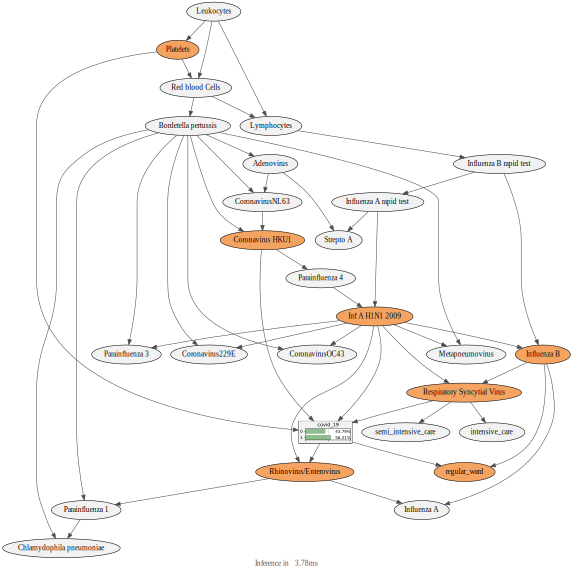

In [28]:
MB = gum.MarkovBlanket(clf.bn,'covid_19')

gnb.showInference(clf.bn,
                  nodeColor={n:0.9 for n in clf.bn.names()},
                  evs=evidence,
                  targets={'covid_19'},
                  size=8)

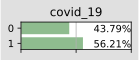

In [29]:
from  random import choice
id = choice(list(clf.bn.nodes().difference(MB.nodes())))
gnb.showPosterior(clf.bn,
                  evs={'Platelets': '3.0',
                        'Inf A H1N1 2009': 'not_detected',
                        'Influenza B': 'detected',
                        'Respiratory Syncytial Virus': 'detected',
                        'Coronavirus HKU1': 'detected',
                        'Rhinovirus/Enterovirus': 'not_detected',
                        'regular_ward': 0,
                      clf.bn.variable(id).name():1},
                  target= 'covid_19')

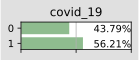

In [30]:
from  random import choice
id1 = choice(list(clf.bn.nodes().difference(MB.nodes())))
id2 = choice(list(clf.bn.nodes().difference(MB.nodes())))

gnb.showPosterior(clf.bn, # we specify the BN to reason with
                  evs={'Platelets': '3.0',
                        'Inf A H1N1 2009': 'not_detected',
                        'Influenza B': 'detected',
                        'Respiratory Syncytial Virus': 'detected',
                        'Coronavirus HKU1': 'detected',
                        'Rhinovirus/Enterovirus': 'not_detected',
                        'regular_ward': 0,
                      clf.bn.variable(id1).name():1,
                      clf.bn.variable(id2).name():0},## observe outside of MB
                  target= 'covid_19')

## Consideraciones de almacenamiento

In [31]:
get_jpd_size(clf.bn)

6347497291776

In [32]:
get_cpts_size(clf.bn)

817

In [33]:
compression_ratio(clf.bn)

99.99999998712879

## Referencias

- https://github.com/AlvaroCorrales/BayesianNetworks/blob/main/Bayesian_Networks_Tutorial_covid-19.ipynb